In [ ]:
import pandas as pd
import numpy as np

from modeling.linear_models import LinearRegressions
from modeling.plots import plot_data, plot_daily_data

In [68]:
SolarData22 = pd.read_csv('../data/Processed/Solar2022.csv',index_col=0,parse_dates=[0])
SolarData23 = pd.read_csv('../data/Processed/Solar2023.csv',index_col=0,parse_dates=[0])
SolarData24 = pd.read_csv('../data/Processed/Solar2024.csv',index_col=0,parse_dates=[0])

#Restrict to when sun ~above horizon
SolarDataDay22 = SolarData22[SolarData22['Solar Zenith Angle']<np.pi/2]
SolarDataDay23 = SolarData23[SolarData23['Solar Zenith Angle']<np.pi/2]
SolarDataDay24 = SolarData24[SolarData24['Solar Zenith Angle']<np.pi/2]

SolarTrain = pd.concat([SolarDataDay22,SolarDataDay23]).dropna()
SolarTest = SolarDataDay24.copy().dropna()

In [69]:
LinearModels = LinearRegressions(SolarTrain,SolarTest)

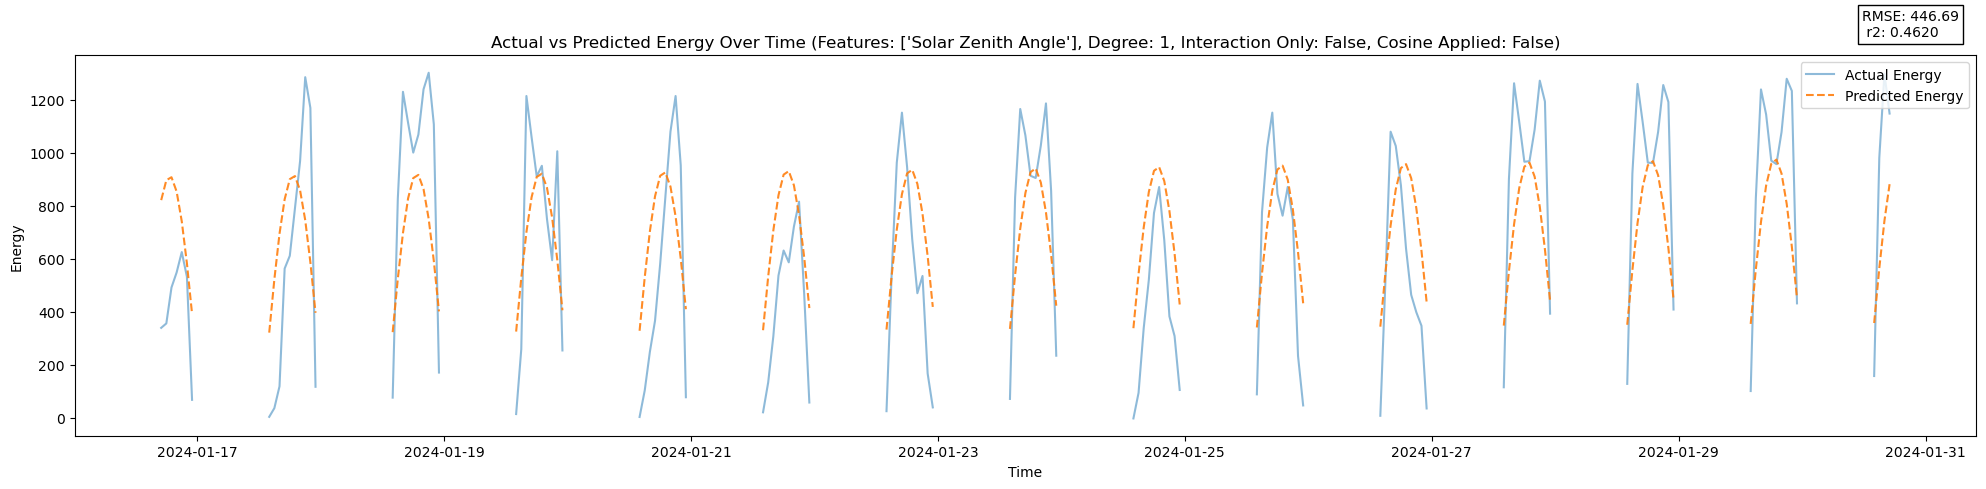

In [70]:
key = (['Solar Zenith Angle'],1,False,False)
LinearModels.fit(*key)
plot_data('Features: {}, Degree: {}, Interaction Only: {}, Cosine Applied: {}'.format(*key),LinearModels.predictions(*key))

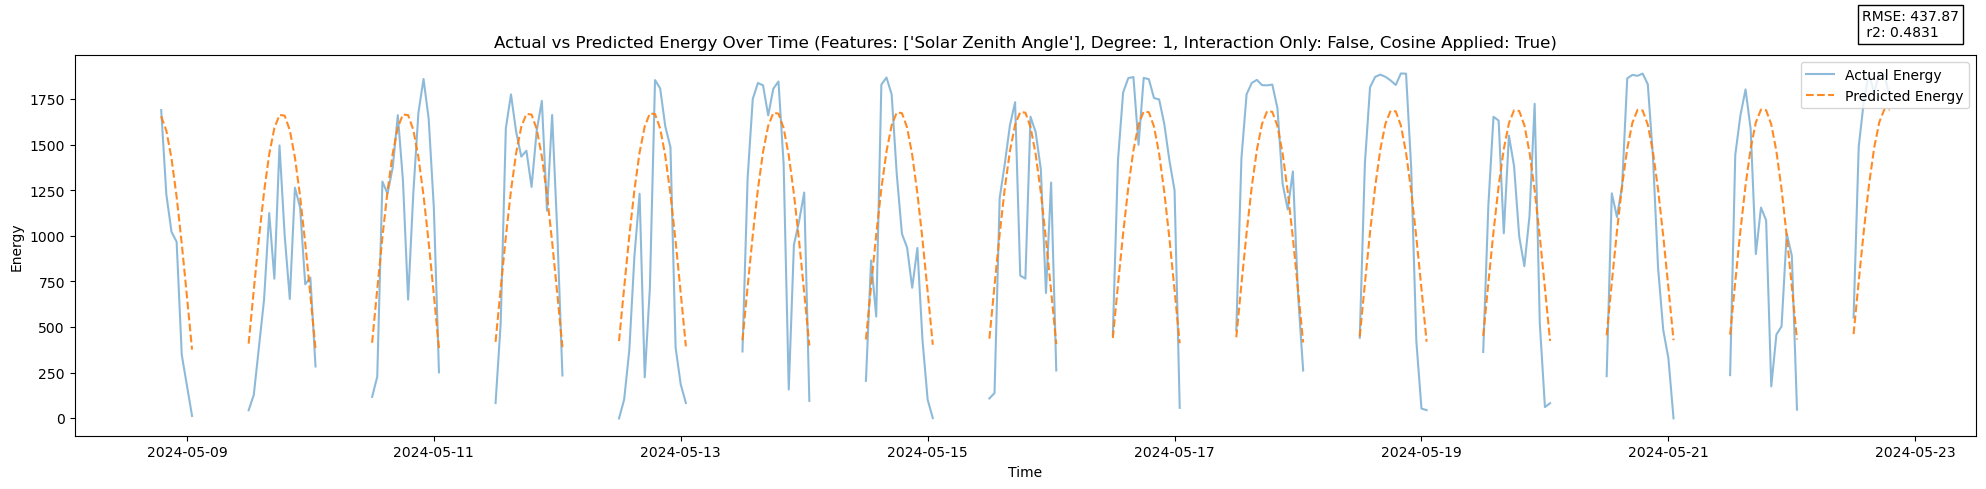

In [71]:
key = (['Solar Zenith Angle'],1,False,True)
LinearModels.fit(*key)
plot_data('Features: {}, Degree: {}, Interaction Only: {}, Cosine Applied: {}'.format(*key),LinearModels.predictions(*key))

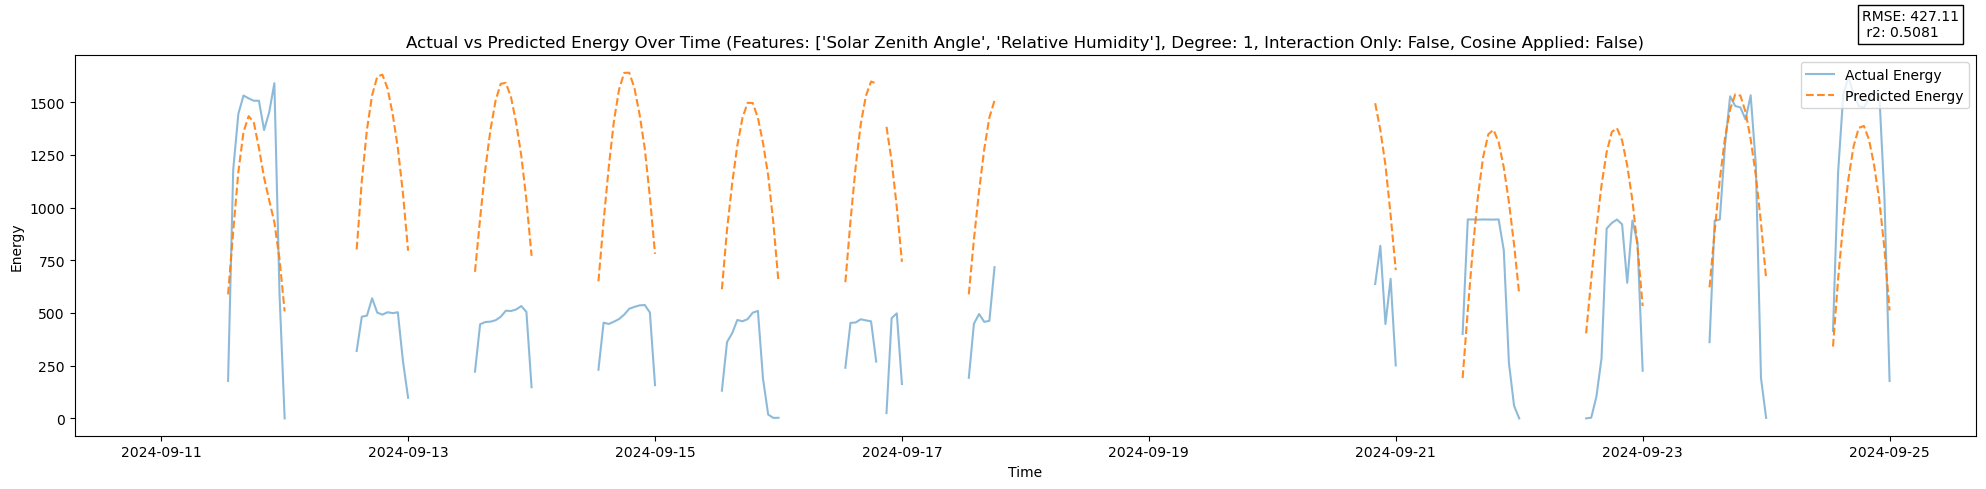

In [72]:
key = (['Solar Zenith Angle','Relative Humidity'],1,False,False)
LinearModels.fit(*key)
plot_data('Features: {}, Degree: {}, Interaction Only: {}, Cosine Applied: {}'.format(*key),LinearModels.predictions(*key))

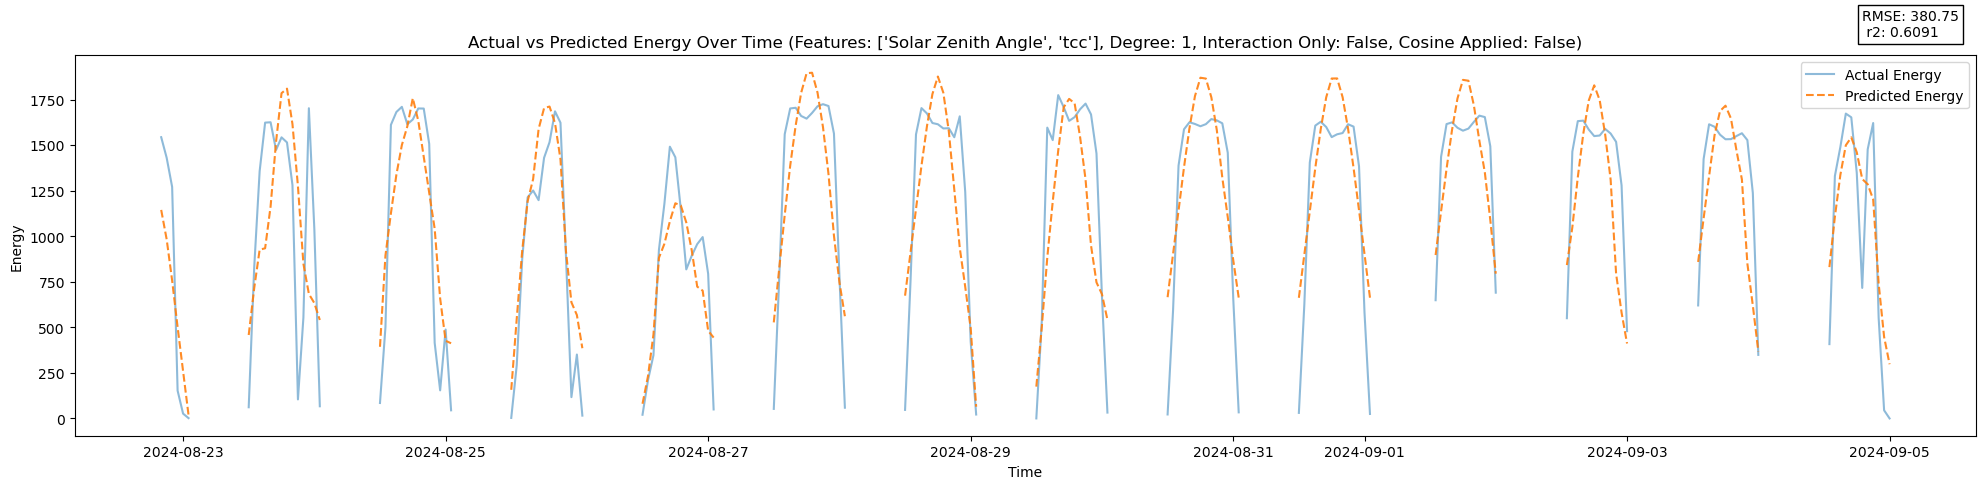

In [73]:
key = (['Solar Zenith Angle','tcc'],1,False,False)
LinearModels.fit(*key)
plot_data('Features: {}, Degree: {}, Interaction Only: {}, Cosine Applied: {}'.format(*key),LinearModels.predictions(*key))

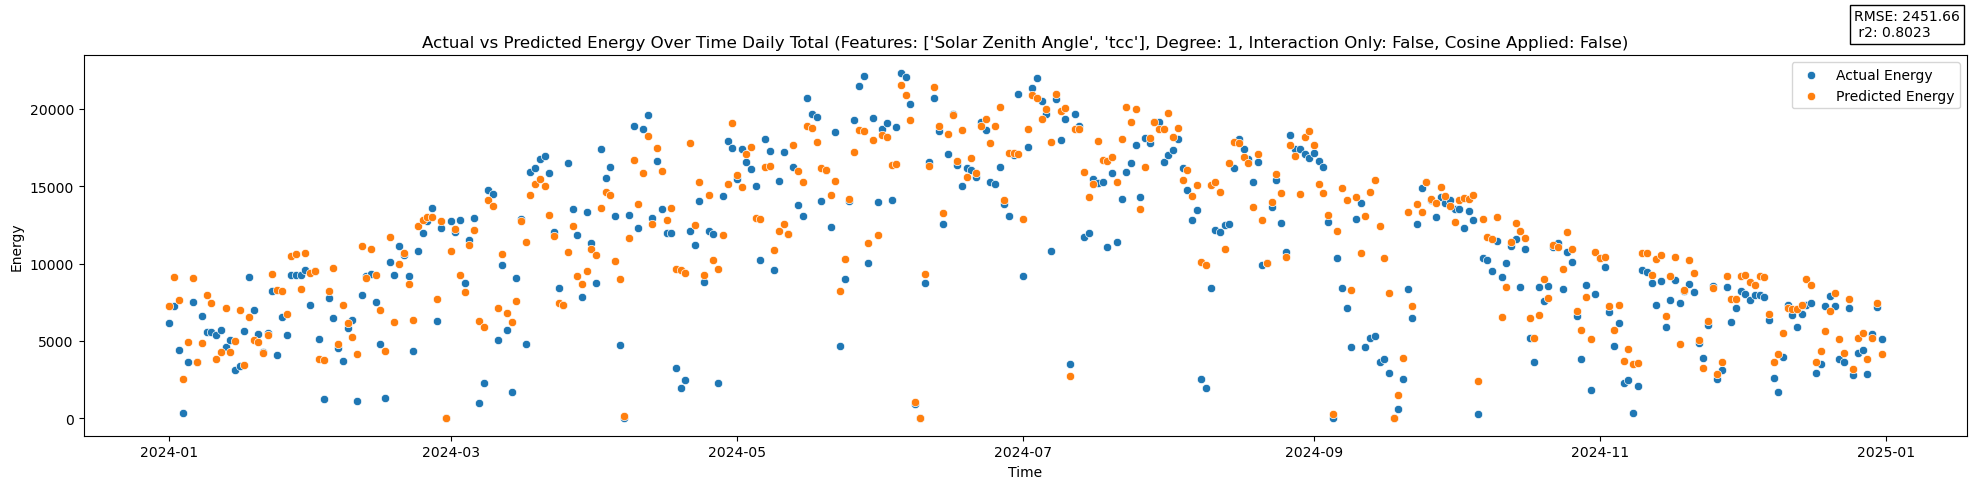

In [74]:
plot_daily_data('Features: {}, Degree: {}, Interaction Only: {}, Cosine Applied: {}'.format(*key),LinearModels.predictions(*key))

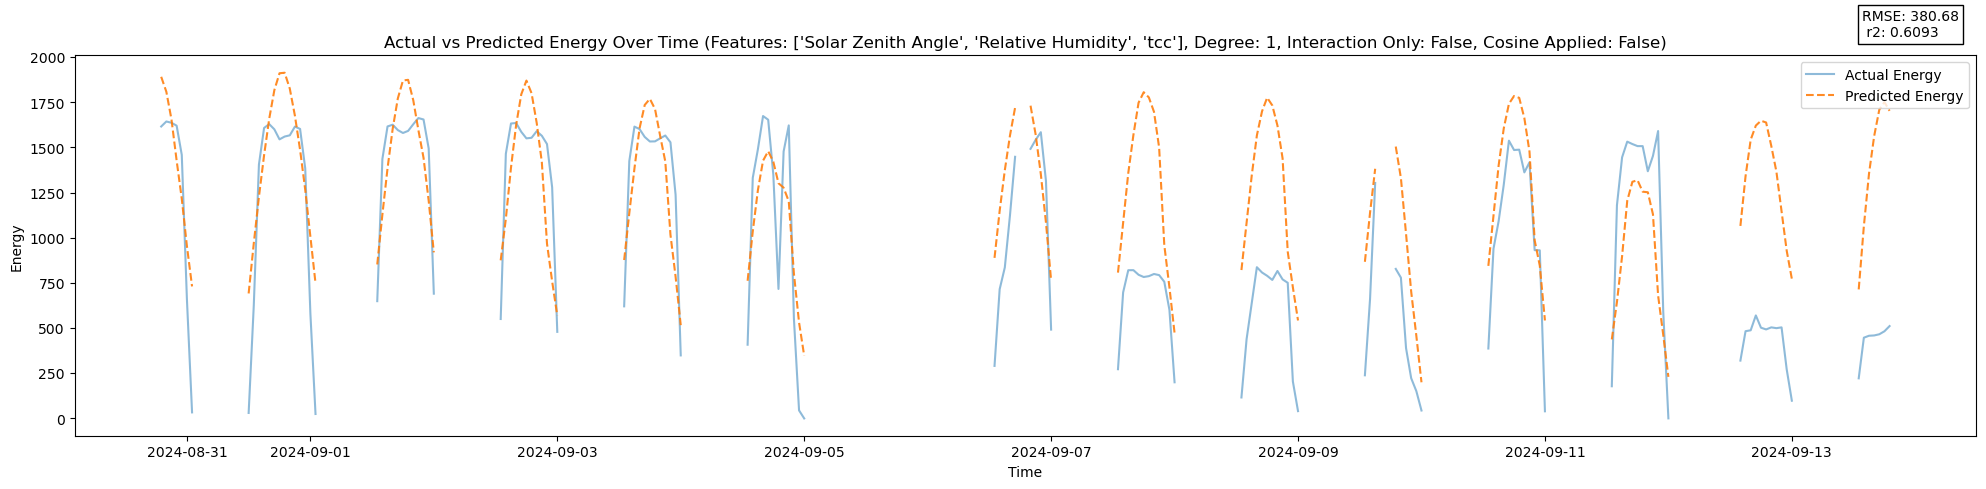

In [75]:
key = (['Solar Zenith Angle','Relative Humidity','tcc'],1,False,False)
LinearModels.fit(*key)
plot_data('Features: {}, Degree: {}, Interaction Only: {}, Cosine Applied: {}'.format(*key),LinearModels.predictions(*key))

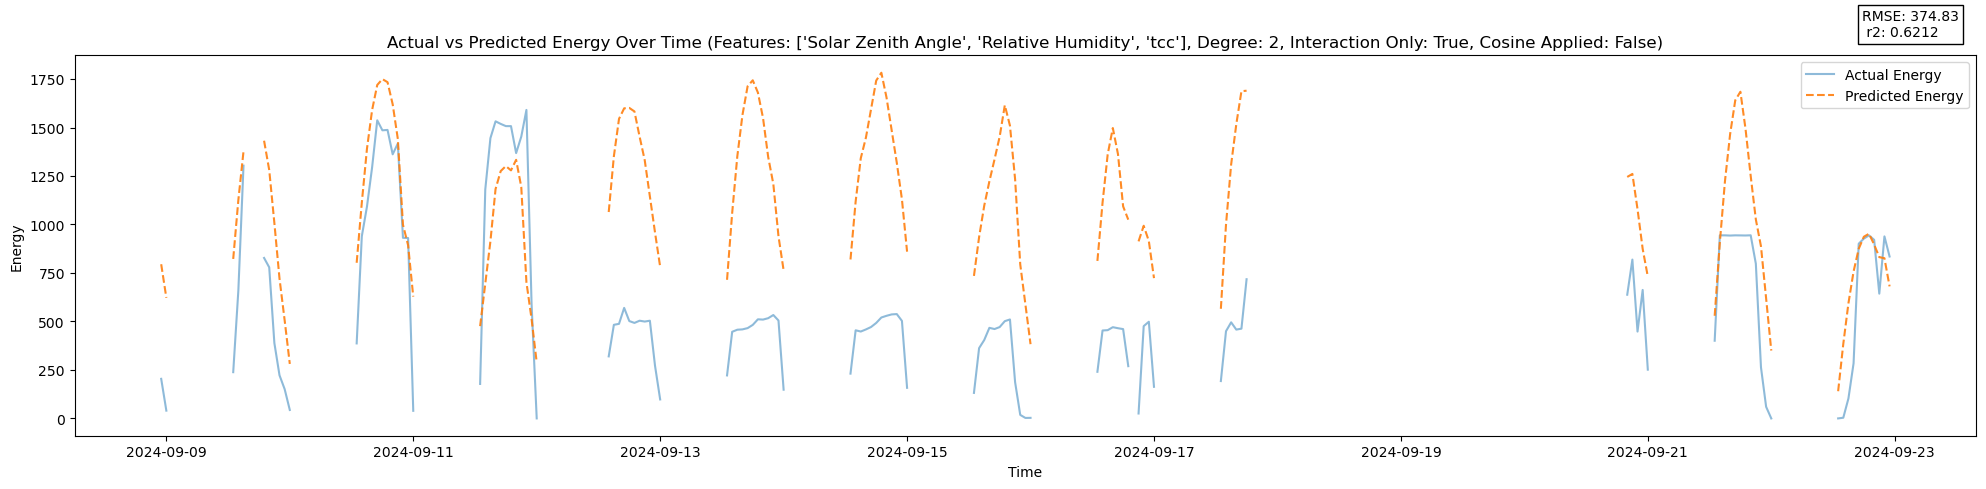

In [76]:
key = (['Solar Zenith Angle','Relative Humidity','tcc'],2,True,False)
LinearModels.fit(*key)
plot_data('Features: {}, Degree: {}, Interaction Only: {}, Cosine Applied: {}'.format(*key),LinearModels.predictions(*key))

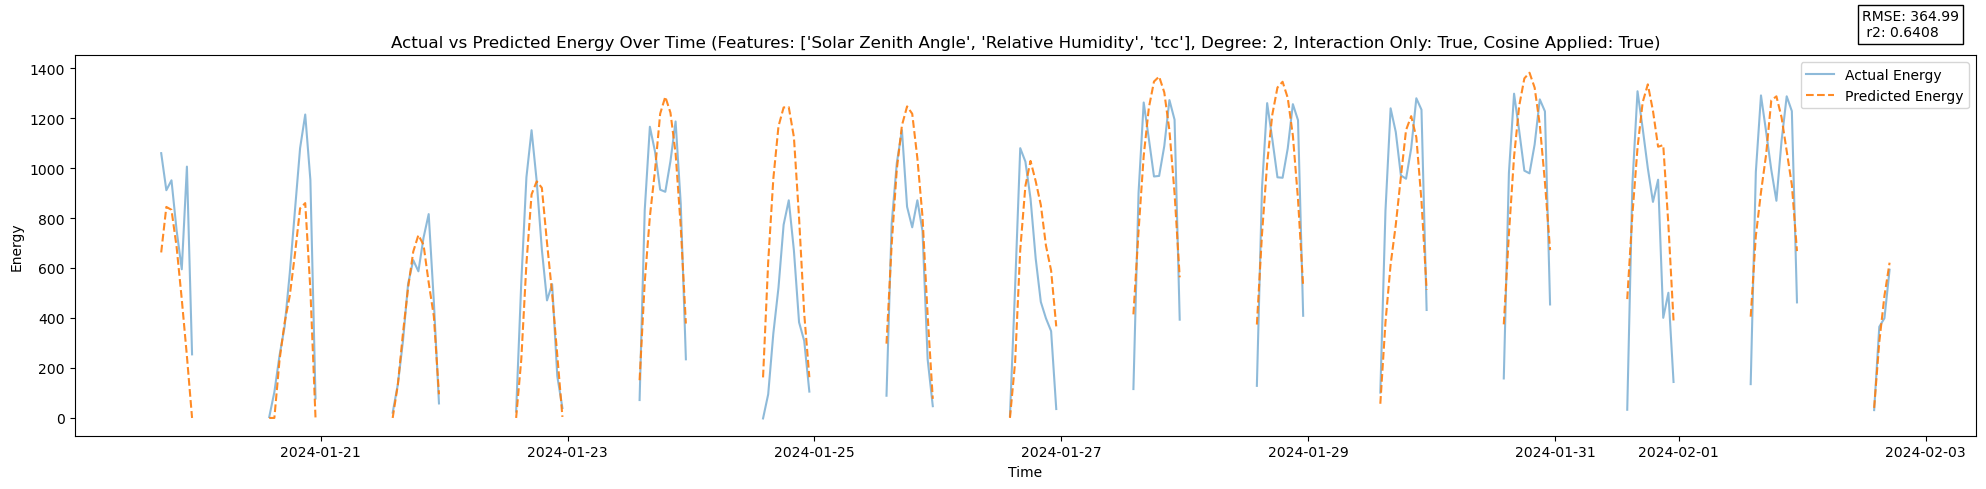

In [77]:
key = (['Solar Zenith Angle','Relative Humidity','tcc'],2,True,True)
LinearModels.fit(*key)
plot_data('Features: {}, Degree: {}, Interaction Only: {}, Cosine Applied: {}'.format(*key),LinearModels.predictions(*key))

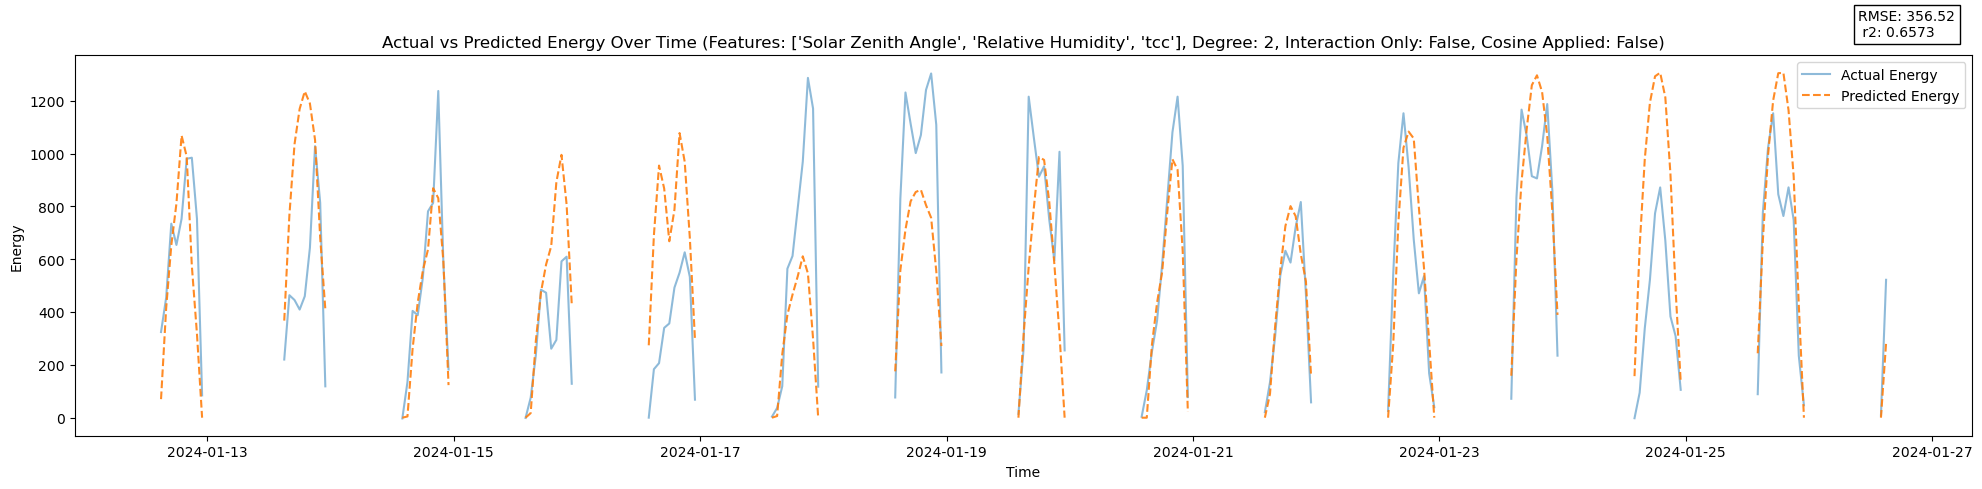

In [78]:
key = (['Solar Zenith Angle','Relative Humidity','tcc'],2,False,False)
LinearModels.fit(*key)
plot_data('Features: {}, Degree: {}, Interaction Only: {}, Cosine Applied: {}'.format(*key),LinearModels.predictions(*key))

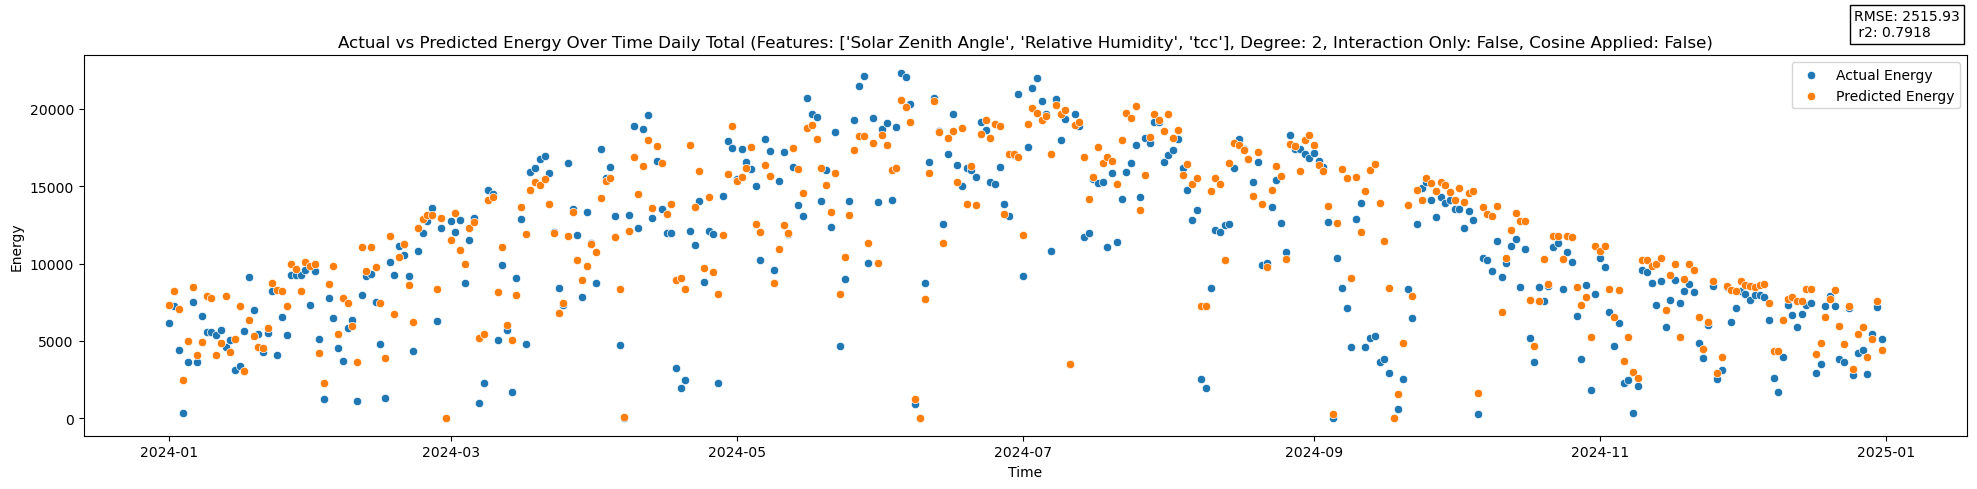

In [79]:
plot_daily_data('Features: {}, Degree: {}, Interaction Only: {}, Cosine Applied: {}'.format(*key),LinearModels.predictions(*key))

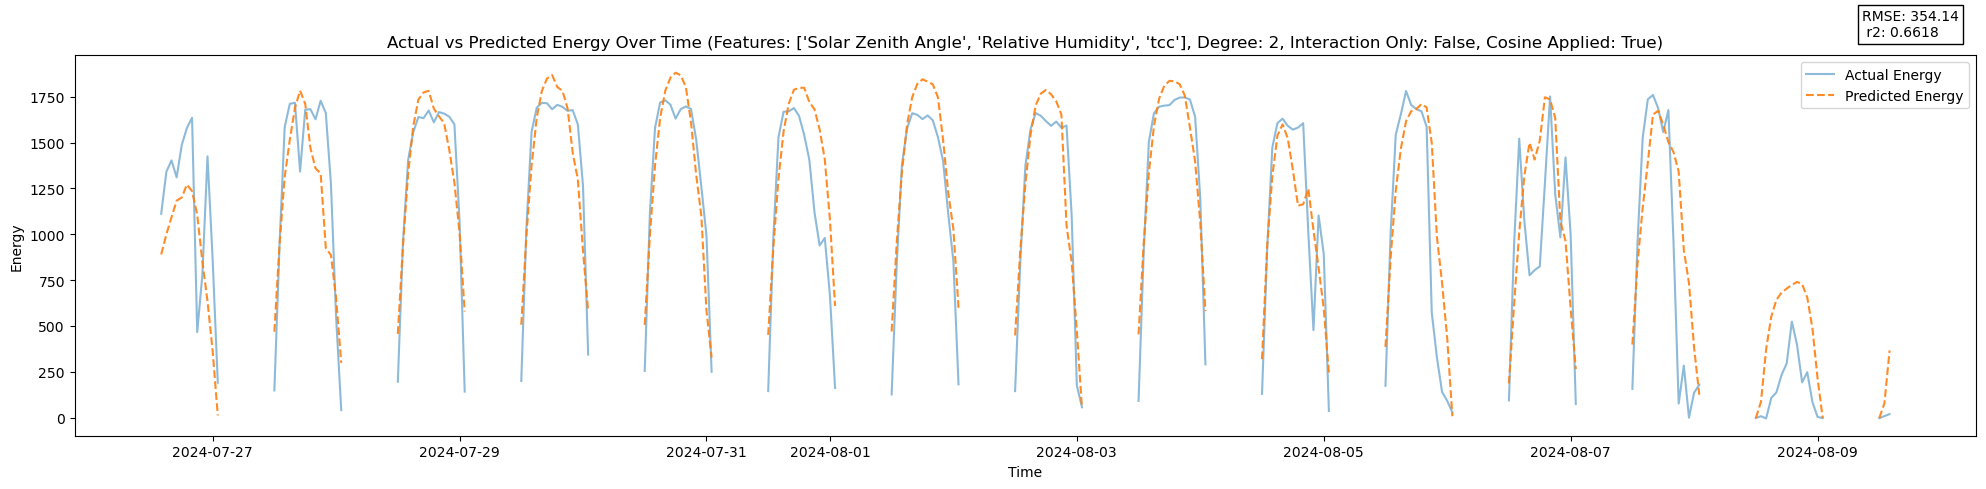

In [80]:
key = (['Solar Zenith Angle','Relative Humidity','tcc'],2,False,True)
LinearModels.fit(*key)
plot_data('Features: {}, Degree: {}, Interaction Only: {}, Cosine Applied: {}'.format(*key),LinearModels.predictions(*key))

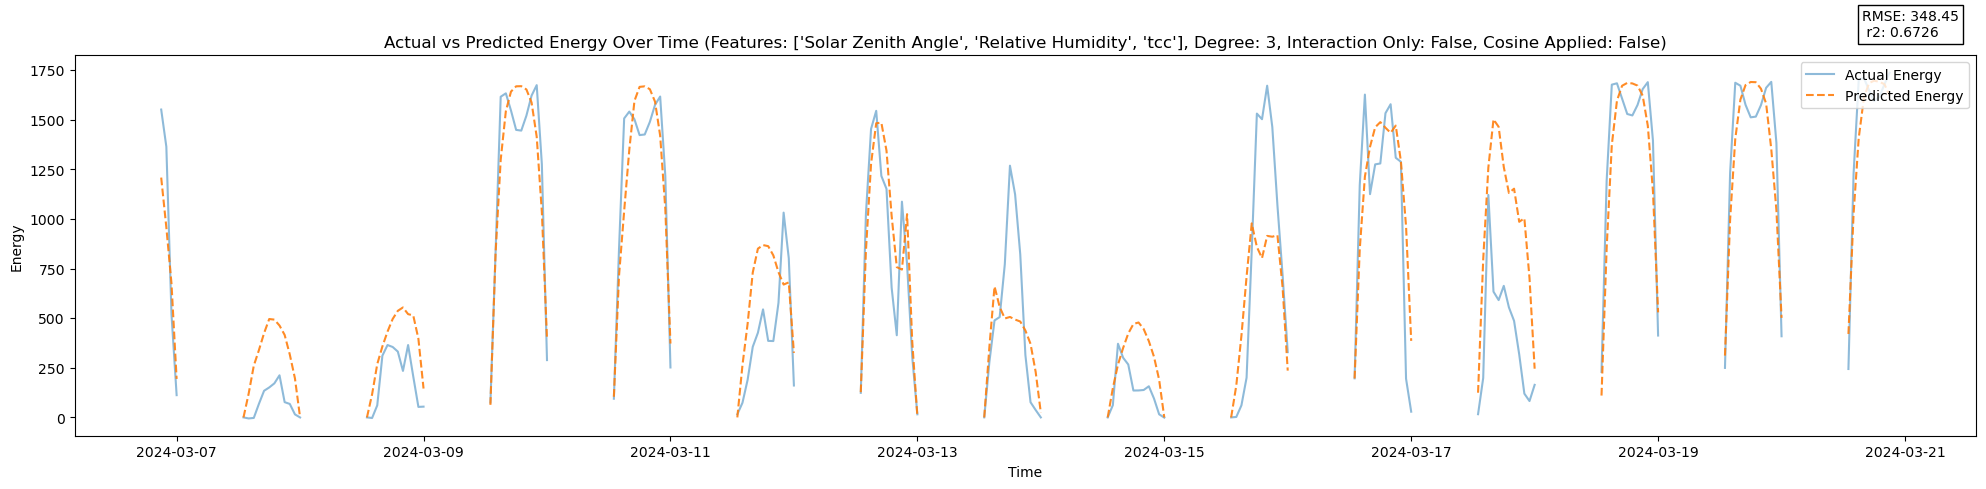

In [81]:
key = (['Solar Zenith Angle','Relative Humidity','tcc'],3,False,False)
LinearModels.fit(*key)
plot_data('Features: {}, Degree: {}, Interaction Only: {}, Cosine Applied: {}'.format(*key),LinearModels.predictions(*key))

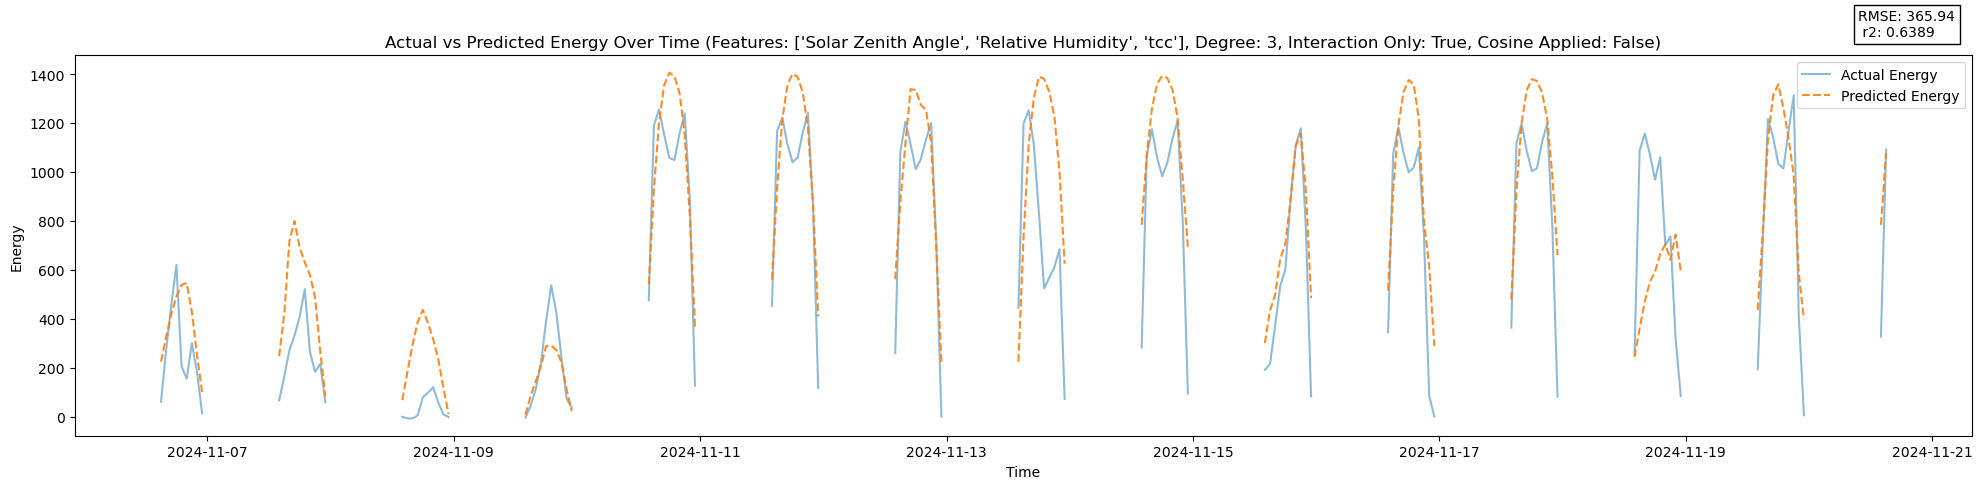

In [82]:
key = (['Solar Zenith Angle','Relative Humidity','tcc'],3,True,False)
LinearModels.fit(*key)
plot_data('Features: {}, Degree: {}, Interaction Only: {}, Cosine Applied: {}'.format(*key),LinearModels.predictions(*key))

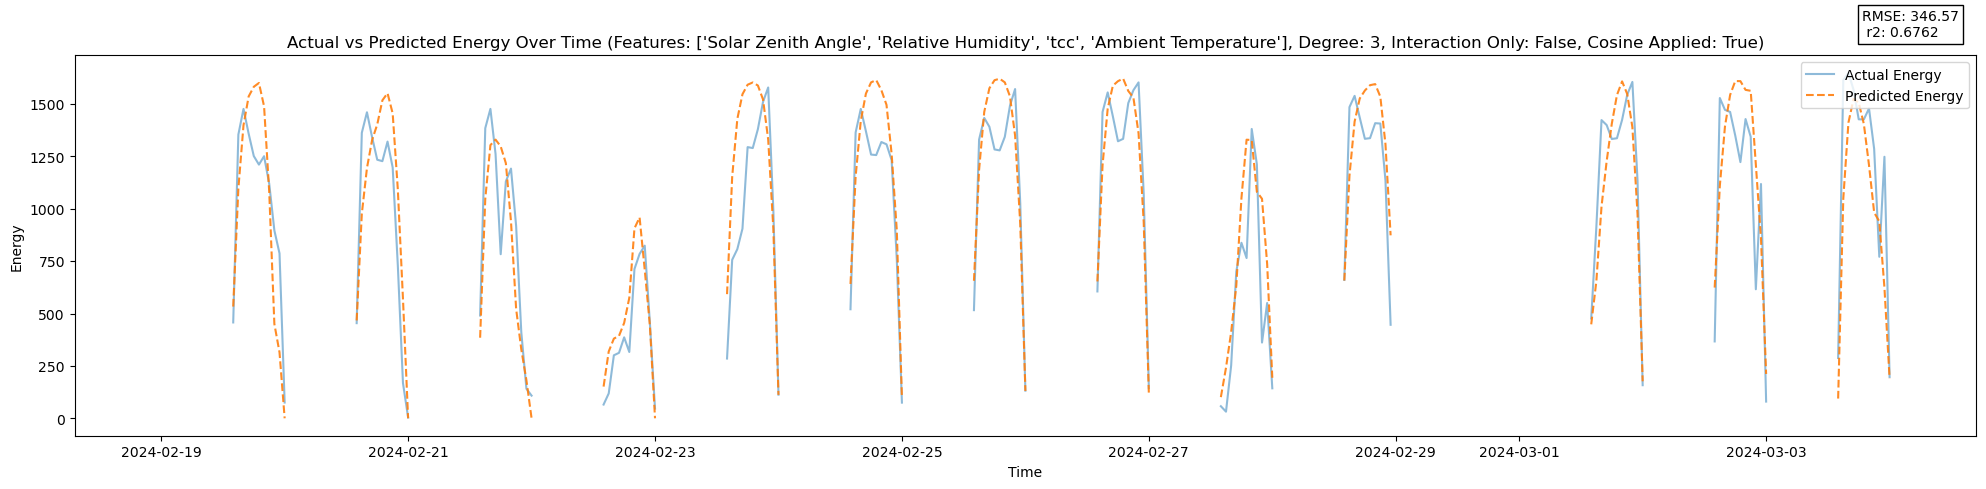

In [83]:
key = (['Solar Zenith Angle','Relative Humidity','tcc','Ambient Temperature'],3,False,True)
LinearModels.fit(*key)
plot_data('Features: {}, Degree: {}, Interaction Only: {}, Cosine Applied: {}'.format(*key),LinearModels.predictions(*key))

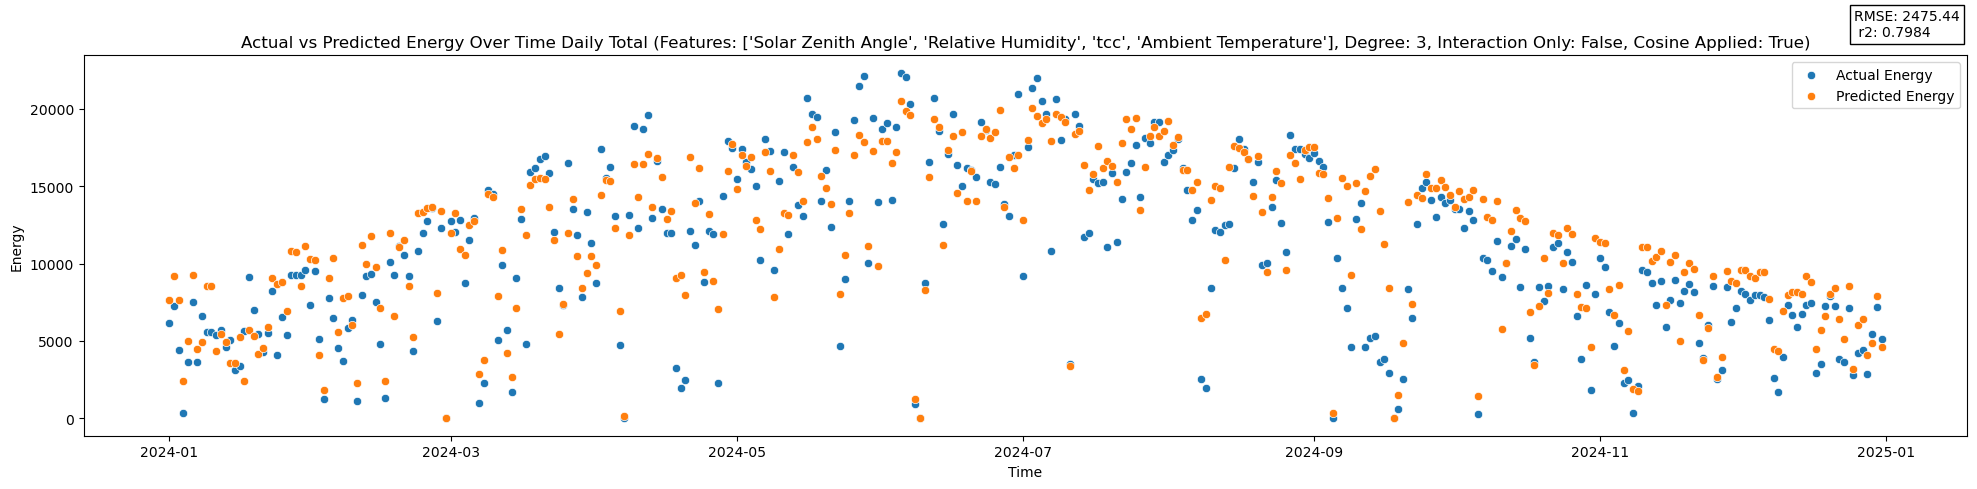

In [84]:
plot_daily_data('Features: {}, Degree: {}, Interaction Only: {}, Cosine Applied: {}'.format(*key),LinearModels.predictions(*key))

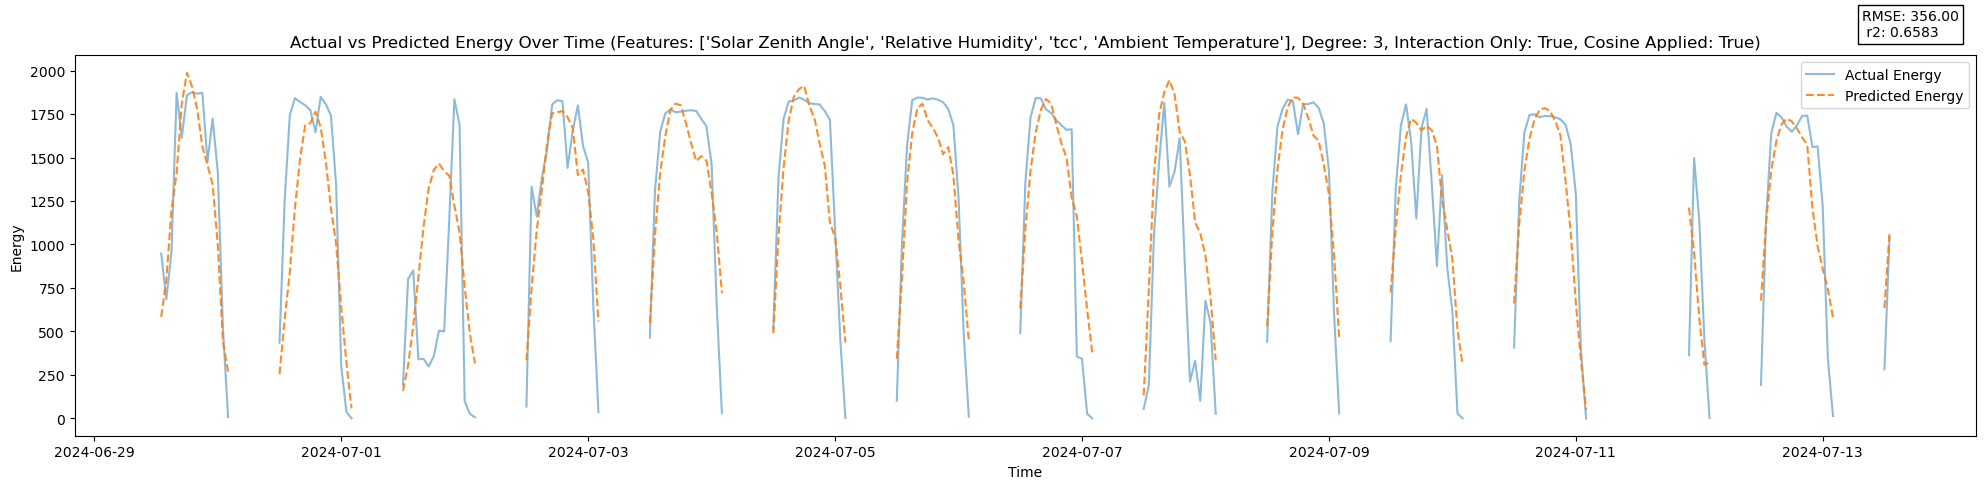

In [85]:
key = (['Solar Zenith Angle','Relative Humidity','tcc','Ambient Temperature'],3,True,True)
LinearModels.fit(*key)
plot_data('Features: {}, Degree: {}, Interaction Only: {}, Cosine Applied: {}'.format(*key),LinearModels.predictions(*key))

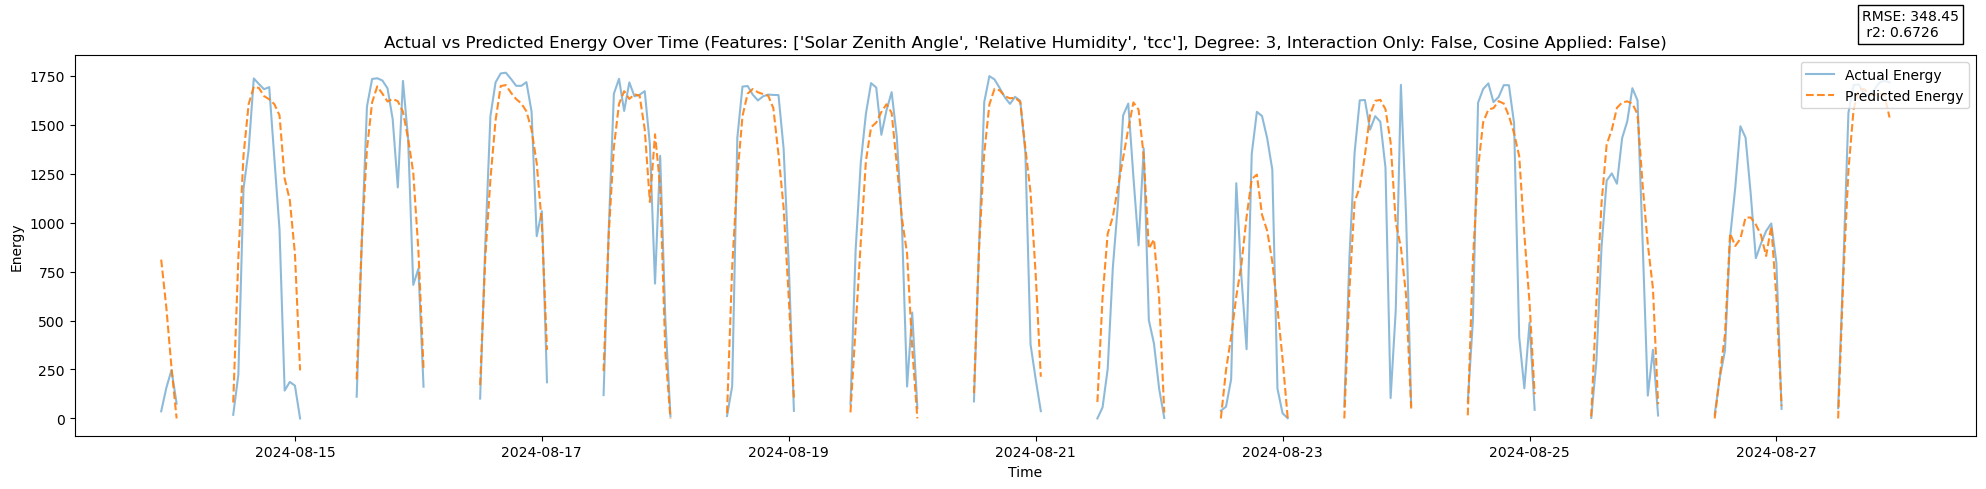

In [88]:
key = (['Solar Zenith Angle','Relative Humidity','tcc'],3,False,False)
LinearModels.fit(*key)
plot_data('Features: {}, Degree: {}, Interaction Only: {}, Cosine Applied: {}'.format(*key),LinearModels.predictions(*key))

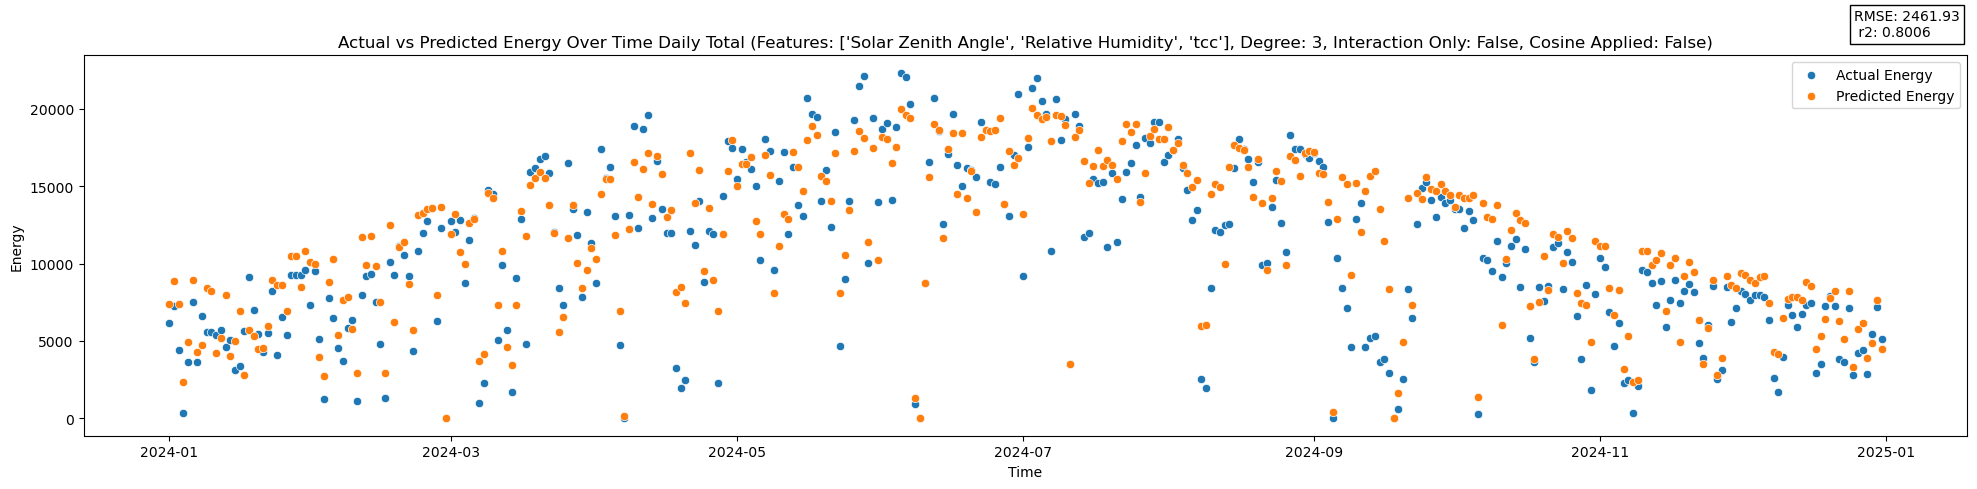

In [89]:
plot_daily_data('Features: {}, Degree: {}, Interaction Only: {}, Cosine Applied: {}'.format(*key),LinearModels.predictions(*key))

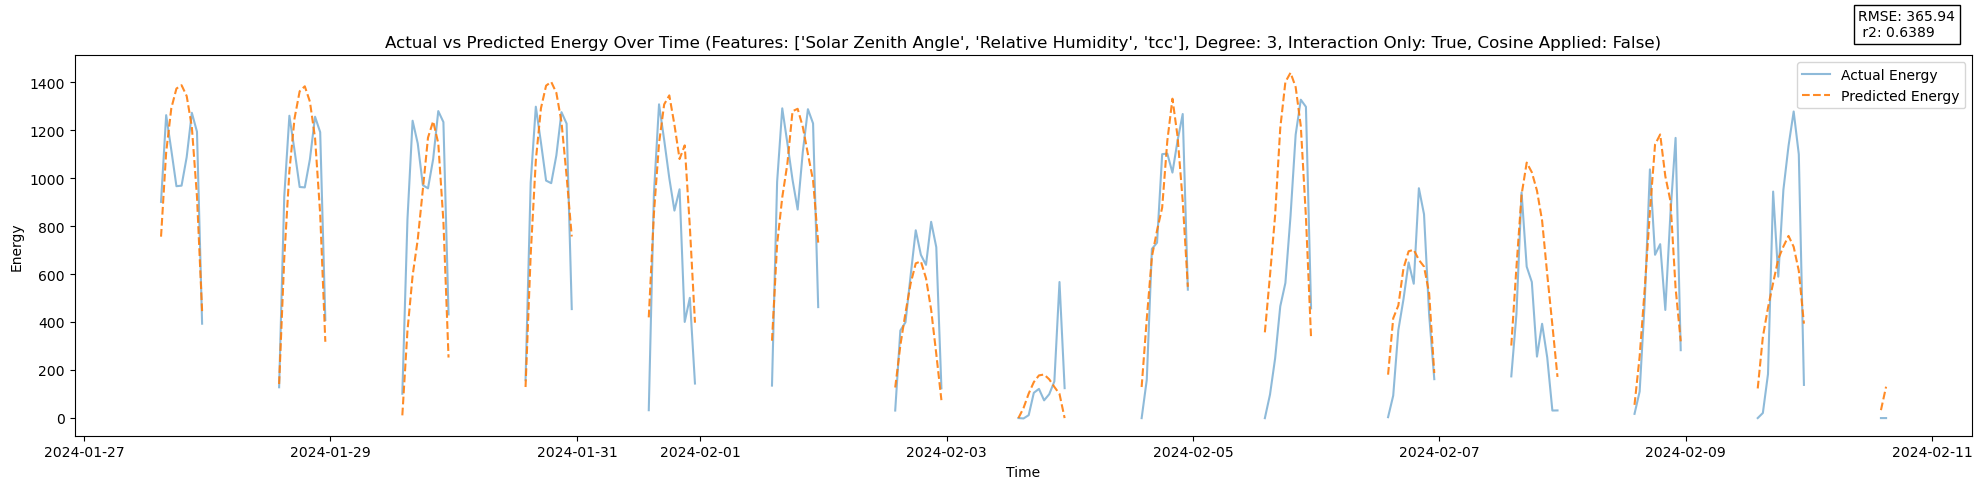

In [87]:
key = (['Solar Zenith Angle','Relative Humidity','tcc'],3,True,False)
LinearModels.fit(*key)
plot_data('Features: {}, Degree: {}, Interaction Only: {}, Cosine Applied: {}'.format(*key),LinearModels.predictions(*key))